# Neural Network model development
Created by Ivan Lima on Thu Dec  9 2021 13:08:20 -0500

In this notebook we develop a neural network model to predict DIC and TA from the merged bottle and satellite data using pytorch.

This version of the neural network model does not include satellite data as input features.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings, joblib
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Mon Mar  7 10:27:48 2022


In [2]:
sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5], 'axes.grid':True})
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

## Read merged bottle satellite data 

In [3]:
df = pd.read_csv('data/bottle_satellite_data_clean.csv', parse_dates=['Date'], index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2601 entries, 0 to 3039
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   X.x                  2601 non-null   int64         
 1   X.y                  2601 non-null   int64         
 2   DOI                  2601 non-null   object        
 3   EXPOCODE             1466 non-null   object        
 4   Accession            101 non-null    float64       
 5   Cruise_ID            2022 non-null   object        
 6   Date                 2601 non-null   datetime64[ns]
 7   Year                 2601 non-null   int64         
 8   Month                2601 non-null   int64         
 9   Day                  2601 non-null   int64         
 10  Time_UTC             2521 non-null   object        
 11  Latitude             2601 non-null   float64       
 12  Longitude            2601 non-null   float64       
 13  Depth_bottom         1341 non-nul

## Select input features and split data into training and test sets 

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Set input and output variables
features = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'pCO2_monthave']
targets  = ['DIC', 'TA']

X_numpy = df[features].values
Y_numpy = df[targets].values

# Split data into training and test sets
X_numpy_train, X_numpy_test, Y_numpy_train, Y_numpy_test = train_test_split(X_numpy, Y_numpy, random_state=42)

### Correlation between feature and target variables 

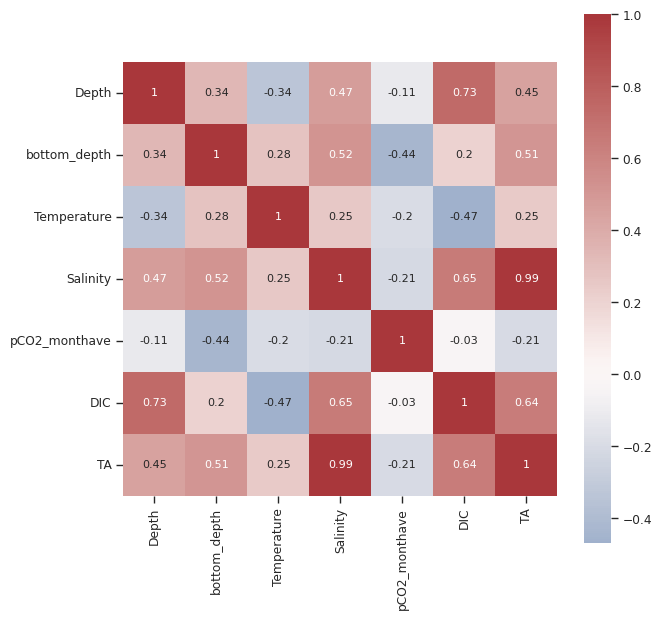

In [5]:
data = df[features + targets]
corr_mat = data.corr()
fig, ax = plt.subplots(figsize=(7,7))
_ = sns.heatmap(corr_mat, ax=ax, cmap='vlag', center=0, square=True, annot=True, annot_kws={'fontsize':8})

## Rescale data 

Neural networks are very sensitive to the scale and distribution of each feature. Therefore, we rescale input features so they have $\overline{x}=0$ and $\sigma=1$.

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = StandardScaler().fit(X_numpy_train)
X_numpy_train_scaled = scaler.transform(X_numpy_train)
X_numpy_test_scaled = scaler.transform(X_numpy_test)
X_numpy_scaled = scaler.transform(X_numpy)

## Neural Network regression 

In [7]:
import torch
import torch.nn as nn

# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # device

# convert numpy arrays to pytorch tensors
X_train = torch.from_numpy(X_numpy_train_scaled.astype(np.float32))
Y_train = torch.from_numpy(Y_numpy_train.astype(np.float32))
# print('X size: {}\nY size: {}'.format(X_train.size(), Y_train.size()))

# set neural network parameters
n_features = X_train.size()[1] # number of input variables
n_targets = Y_train.size()[1]  # number of output variables
n_hidden = 256                 # number of hidden layers
learning_rate = 0.001

torch.manual_seed(42) # set random number seed to make things reproducible

# create neural network regression model
class MLPReg(nn.Module):
    def __init__(self, n_features, n_hidden, n_targets):
        super(MLPReg, self).__init__()
        self.l1    = nn.Linear(n_features, n_hidden)
        self.l2    = nn.Linear(n_hidden, n_hidden)
        self.l3    = nn.Linear(n_hidden, n_targets)
        self.activ = nn.LeakyReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.activ(out)
        out = self.l2(out)
        out = self.activ(out)
        out = self.l3(out)
        return out

nn_reg = MLPReg(n_features=n_features, n_hidden=n_hidden, n_targets=n_targets) # create model instance
print(nn_reg)

loss_func = nn.MSELoss()                                                      # loss function (mean square error)
optimizer = torch.optim.Adam(nn_reg.parameters(), lr=learning_rate)           # optimizer

loss_vals = [] # keep loss function values for plotting

# train the model
n_passes = 10000
for n in range(n_passes):
    # forward pass
    prediction = nn_reg(X_train)
    loss = loss_func(prediction, Y_train)
    # backward pass
    optimizer.zero_grad()   # clear accumulated gradients for next pass
    loss.backward()         # do backpropagation to compute gradients
    optimizer.step()        # apply gradients to update parameters
    loss_vals.append(loss.item())
    if (n==0) or ((n+1) % 1000 == 0):
        print('pass {:5d}/{}, MSE={:.2f}'.format(n+1, n_passes, loss.item()))

MLPReg(
  (l1): Linear(in_features=5, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=2, bias=True)
  (activ): LeakyReLU(negative_slope=0.01)
)
pass     1/10000, MSE=4726500.50
pass  1000/10000, MSE=30637.18
pass  2000/10000, MSE=5353.05
pass  3000/10000, MSE=453.57
pass  4000/10000, MSE=277.19
pass  5000/10000, MSE=242.16
pass  6000/10000, MSE=221.84
pass  7000/10000, MSE=204.94
pass  8000/10000, MSE=190.66
pass  9000/10000, MSE=178.39
pass 10000/10000, MSE=167.92


### Loss function as function of number of passes

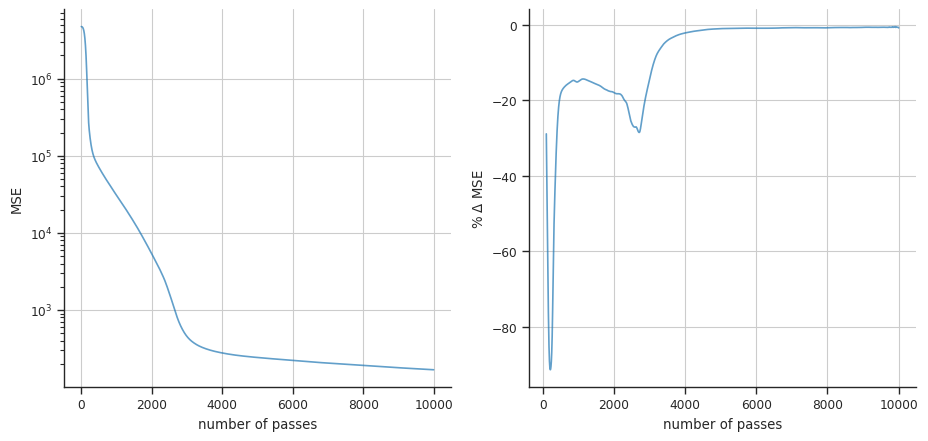

In [8]:
df = pd.DataFrame({'MSE': np.array(loss_vals)})
df['pct_change'] = df.MSE.pct_change(100) * 100
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
_ = df.MSE.plot(ax=axs[0], alpha=0.7, legend=False)
_ = df['pct_change'].plot(ax=axs[1], alpha=0.7, legend=False)
_ = axs[0].set(ylabel='MSE', xlabel='number of passes', yscale='log')
_ = axs[1].set(ylabel=r'% $\Delta$ MSE', xlabel='number of passes')
sns.despine(fig)

### Evaluate model on test set

In [9]:
from sklearn.metrics import r2_score

X_test = torch.from_numpy(X_numpy_test_scaled.astype(np.float32))
with torch.no_grad():
    Y_pred_train = nn_reg(X_train)
    Y_pred_test  = nn_reg(X_test)

print('Training set R squared: {:.3f}'.format(r2_score(Y_pred_train, Y_numpy_train)))
print('Test set R squared:     {:.3f}'.format(r2_score(Y_pred_test, Y_numpy_test)))

Training set R squared: 0.965
Test set R squared:     0.948


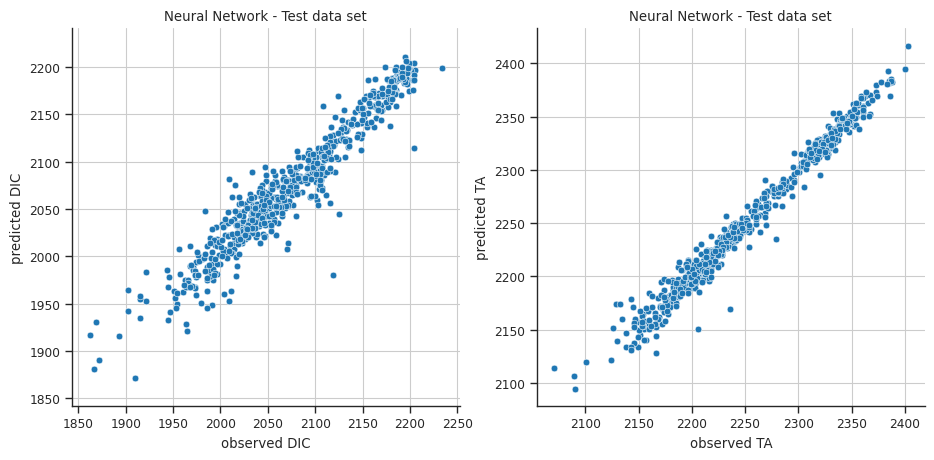

In [10]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11, 5))
_ = sns.scatterplot(x=Y_numpy_test[:,0], y=Y_pred_test[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_numpy_test[:,1], y=Y_pred_test[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Neural Network - Test data set')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Neural Network - Test data set')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

### Save model and scaler for later use

In [11]:
joblib.dump(scaler, 'models/scaler_nosat.joblib') 
torch.save(nn_reg, 'models/nn_reg_nosat.pth')
torch.save(nn_reg.state_dict(), 'models/nn_reg_nosat_state.pth')

### Do k-fold cross-validation

In [12]:
torch.manual_seed(42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

nnr_model = MLPReg(n_features=n_features, n_hidden=n_hidden, n_targets=n_targets)

loss_func = nn.MSELoss() # loss function (mean square error)
optimizer = torch.optim.Adam(nnr_model.parameters(), lr=learning_rate) # optimizer

score_vals = [] # store score values

for k, (train_idx, test_idx) in enumerate(kf.split(X_numpy)):
    # rescale input data
    X_tr, X_te = X_numpy[train_idx], X_numpy[test_idx]
    ss = StandardScaler().fit(X_tr)
    X_tr_sc = ss.transform(X_tr)
    X_te_sc = ss.transform(X_te)
    
    # convert numpy arrays to tensors
    X = torch.from_numpy(X_tr_sc.astype(np.float32))
    Y = torch.from_numpy(Y_numpy[train_idx].astype(np.float32))

    # reset model weights to avoid weight leakage
    nnr_model.apply(reset_weights)
    
    # train the model
    ntot = n_passes
    for n in range(ntot):
        # forward pass
        prediction = nnr_model(X)
        loss = loss_func(prediction, Y)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (n==0) or ((n+1) % 1000 == 0):
            print('pass {:5d}/{}, MSE={:.2f}'.format(n+1, ntot, loss.item()))
    
    # evaluate model
    xx = torch.from_numpy(X_te_sc.astype(np.float32))
    with torch.no_grad():
        Y_pred  = nnr_model(xx)
        score = r2_score(Y_pred, Y_numpy[test_idx])
        score_vals.append(score)
        print('Fold {} test set R squared: {:.3f}\n'.format(k+1, score))

Reset trainable parameters of layer = Linear(in_features=5, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=2, bias=True)
pass     1/10000, MSE=4725949.50
pass  1000/10000, MSE=26447.40
pass  2000/10000, MSE=1189.13
pass  3000/10000, MSE=343.63
pass  4000/10000, MSE=278.55
pass  5000/10000, MSE=248.22
pass  6000/10000, MSE=228.16
pass  7000/10000, MSE=213.71
pass  8000/10000, MSE=202.95
pass  9000/10000, MSE=194.98
pass 10000/10000, MSE=188.16
Fold 1 test set R squared: 0.950

Reset trainable parameters of layer = Linear(in_features=5, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=256, bias=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=2, bias=True)
pass     1/10000, MSE=4717835.50
pass  1000/10000, MSE=2233.36
pass  2000/10000, MSE=357.27
pass  3000

In [13]:
scores = np.array(score_vals)
scores.sort()
with np.printoptions(precision=3, suppress=True):
    print('K-fold cross-validation (k=5) R squared values = {}'.format(scores))
print('Best R squared:  {:.3f}'.format(scores.max()))
print('Worst R squared: {:.3f}'.format(scores.min()))
print('Mean R squared:  {:.3f}'.format(scores.mean()))

K-fold cross-validation (k=5) R squared values = [0.945 0.95  0.95  0.952 0.957]
Best R squared:  0.957
Worst R squared: 0.945
Mean R squared:  0.951
